In [115]:
# Con esto se evalúa el BIC - Bayesian Information Criterion
# De esta manera vemos cual es número ideal de componentes y el mejor método para el clustering
Xbic=XprojL
# H, full, 2 components
# D, full, 6 components
# B, tied, 5 components
# L, full, 11 components
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for kcomp in np.arange(25)+1:
        gmm = GMM(kcomp, covariance_type=cv_type, random_state=0)
        gmm.fit(Xbic)
#        print cv_type,kcomp,gmm.bic(Xbic)

In [1]:
from sklearn.decomposition import PCA
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GMM

In [2]:
# función para convertir los datos de LONLAT a formato legible por el computador
def conversion(old):
    direction = {'N':-1, 'S':1, 'E': -1, 'W':1} # diccionario
    new = old.replace('\xc2\xb0',' ').replace('\'',' ').replace('"',' ')
    new = new.split() # separa grados, minutos, segundos, orientación en una lista de 4 objetos
    new_dir = new.pop() # extrae la orientación
    return (int(new[0])+int(new[1])/60.0+int(float(new[2]))/3600.0) * direction[new_dir]

(445, 2)
0.959021220933
[ 0.84050377  0.11851745]
6908.59204417
Number of stations in cluster 0 is 258
Number of stations in cluster 1 is 187


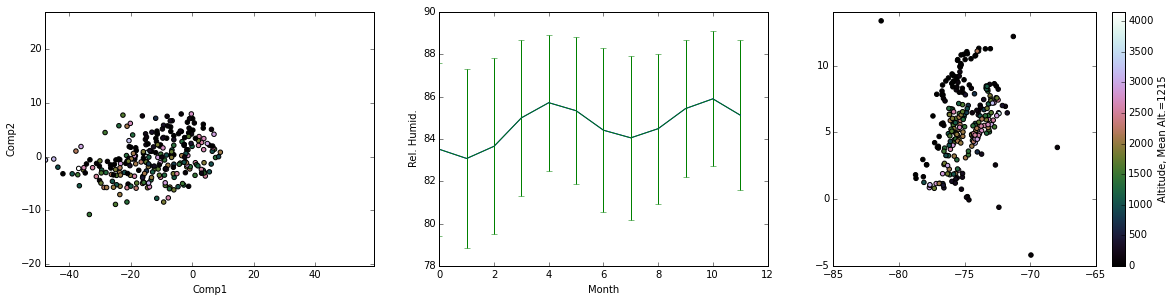

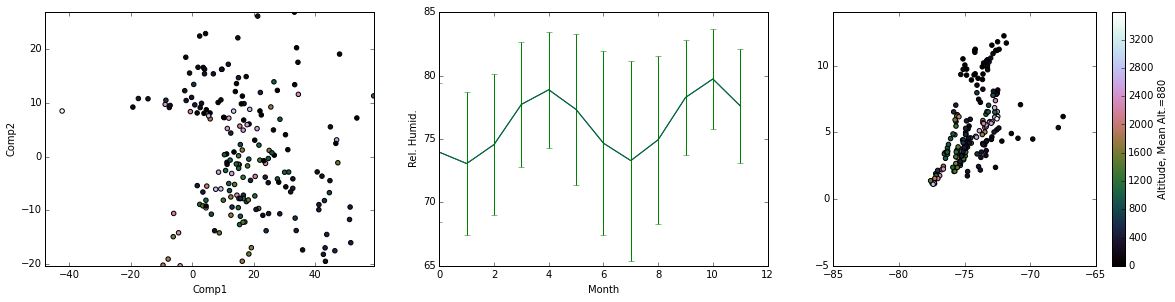

In [3]:
# Para humedad, el PCA cubre >95% de varianza
df=pd.read_csv('humedad.csv')

AH=df.as_matrix(columns=df.columns[8:20])
pca = PCA(2)  
XprojH = pca.fit_transform(AH)
print(XprojH.shape)
print pca.explained_variance_ratio_.sum(axis=0)
print pca.explained_variance_ratio_

# para que las gráficas se vean con los mismos ejes
xmin=min(XprojH[:, 0])
xmax=max(XprojH[:, 0])
ymin=min(XprojH[:, 1])
ymax=max(XprojH[:, 1])

# conversión de formato LATLON
latH=np.zeros(len(df.LATITUD))
lonH=np.zeros(len(df.LATITUD))
codeH=np.zeros(len(df.LATITUD))
for i in range(len(df.LATITUD)):
    latH[i]=conversion(df.LATITUD[i])
    lonH[i]=conversion(df.LONGITUD[i])
    codeH[i]=df.CODIGO[i]
    
# Mixtura gaussiana para kcomp clusters
kcomp=2
gmm = GMM(kcomp, covariance_type='full', random_state=0)
gmm.fit(XprojH)
print gmm.bic(XprojH)
cluster_labelH = gmm.predict(XprojH)


# Se hace una gráfica para cada cluster
for kk in range(kcomp):
    D=np.zeros([sum(cluster_labelH==kk),2])
    B=np.zeros([sum(cluster_labelH==kk),12])
    LAT=np.zeros([sum(cluster_labelH==kk)])
    LON=np.zeros([sum(cluster_labelH==kk)])
    ALTH=np.zeros([sum(cluster_labelH==kk)])
    i=0
    for k in range(len(cluster_labelH)):
        if cluster_labelH[k]==kk:
            B[i]=AH[k]
            D[i]=XprojH[k]
            LAT[i]=latH[k]
            LON[i]=lonH[k]
            ALTH[i]=df.ELEV[k]
            i=i+1
    print "Number of stations in cluster %i is %i" %(kk,i)
    plt.figure(figsize=(20,5*kcomp))
    ii=0

#
    plt.subplot(kcomp, 3, ii+1)
    plt.scatter(D[:, 0], D[:, 1],c=ALTH,cmap='cubehelix')
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xlabel('Comp1')
    plt.ylabel('Comp2')

    xx=np.arange(12)
    plt.subplot(kcomp, 3, ii+2)
    plt.plot(B.mean(axis=0))
    plt.errorbar(xx,B.mean(axis=0),yerr=B.std(axis=0))
    plt.xlabel('Month')
    plt.ylabel('Rel. Humid.')

    plt.subplot(kcomp, 3, ii+3)
    plt.scatter(-LON,-LAT,c=ALTH,cmap='cubehelix')
    plt.colorbar(label='Altitude, Mean Alt.=%i' % ALTH.mean())
    plt.xlim(-85,-65)
    plt.ylim(-5,14)
    ii=ii+3

38


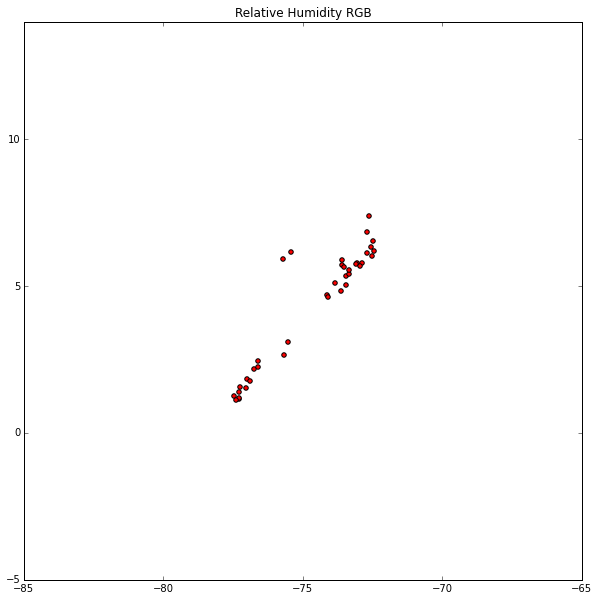

In [4]:
# Esto es para graficarlos todos en una misma gráfica de LATLON. Ahora LAT y LON son arrays
LATH=np.zeros([len(cluster_labelH),kcomp])
LONH=np.zeros([len(cluster_labelH),kcomp])
ALTH=np.zeros([len(cluster_labelH),kcomp])
CODH=np.zeros([len(cluster_labelH),kcomp])
for kk in range(kcomp):
    i=0
    for k in range(len(df)):
        if cluster_labelH[k]==kk:
            LATH[i,kk]=latH[k]
            LONH[i,kk]=lonH[k]
            ALTH[i,kk]=df.ELEV[k]
            CODH[i,kk]=df.CODIGO[k]
            i=i+1
# Los puntos rojos son el segundo cluster, el más interesante para nosotros
# Los siguientes importantes son los verdes (cuarto cluster)
plt.figure(figsize=(10,10))
filter1=ALTH[:,1]>1500
filter0=ALTH[:,0]>1500
plt.scatter(-LONH[:,1][filter1],-LATH[:,1][filter1],c='r')
#plt.scatter(-LONH[:,0][filter0],-LATH[:,0][filter0],c='g')
plt.xlim(-85,-65)
plt.ylim(-5,14)
plt.title("Relative Humidity RGB")
print filter1.sum()

(2046, 12)
(2046, 3)
0.959578491041
[ 0.78211583  0.13516064  0.04230202]
Number of stations in cluster 0 is 67
Number of stations in cluster 1 is 194
Number of stations in cluster 2 is 269
Number of stations in cluster 3 is 114
Number of stations in cluster 4 is 244
Number of stations in cluster 5 is 295
Number of stations in cluster 6 is 185
Number of stations in cluster 7 is 3
Number of stations in cluster 8 is 176
Number of stations in cluster 9 is 56
Number of stations in cluster 10 is 443


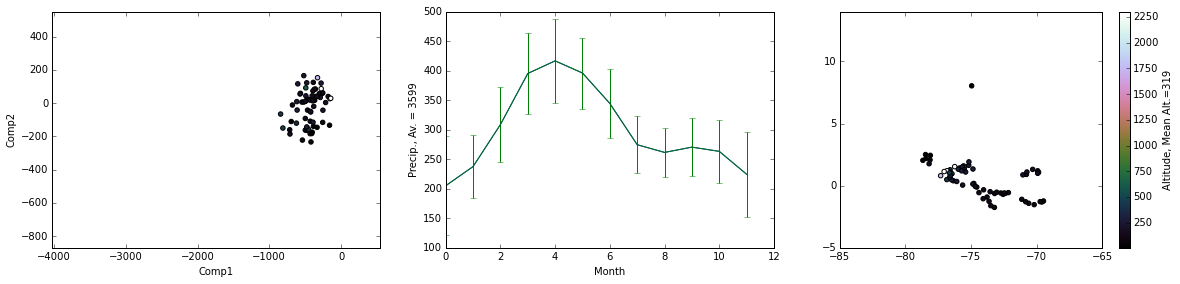

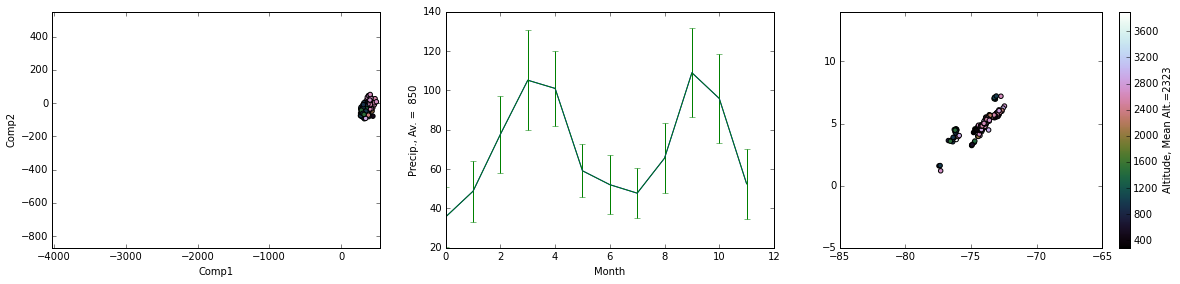

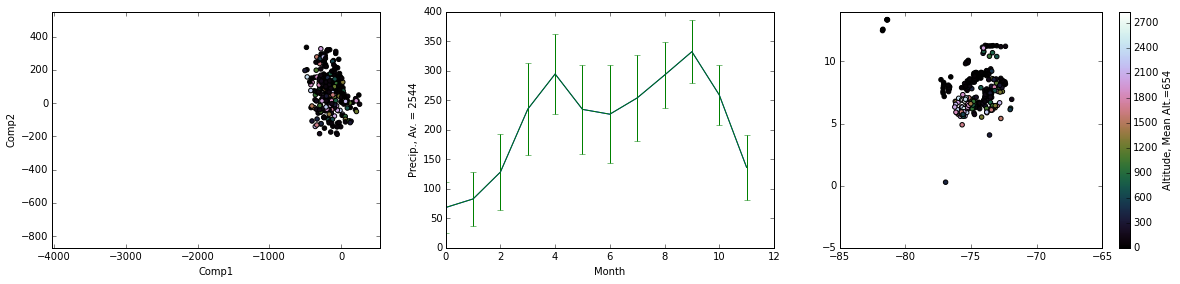

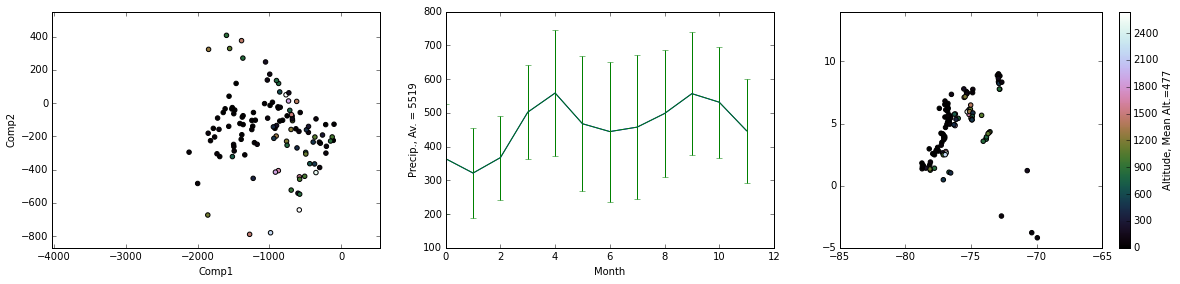

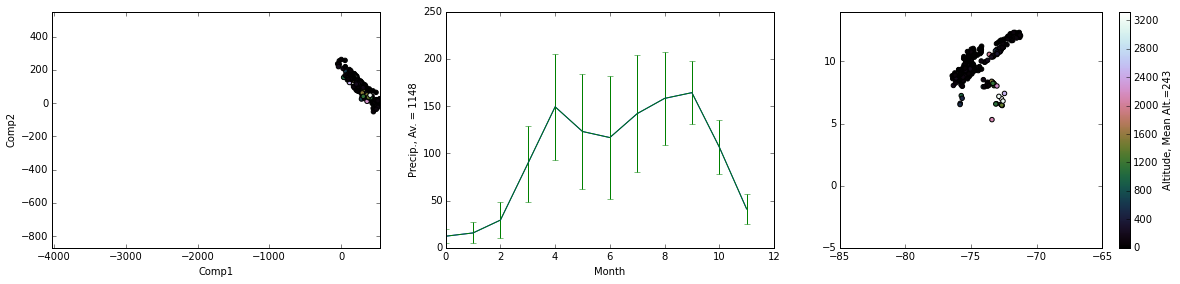

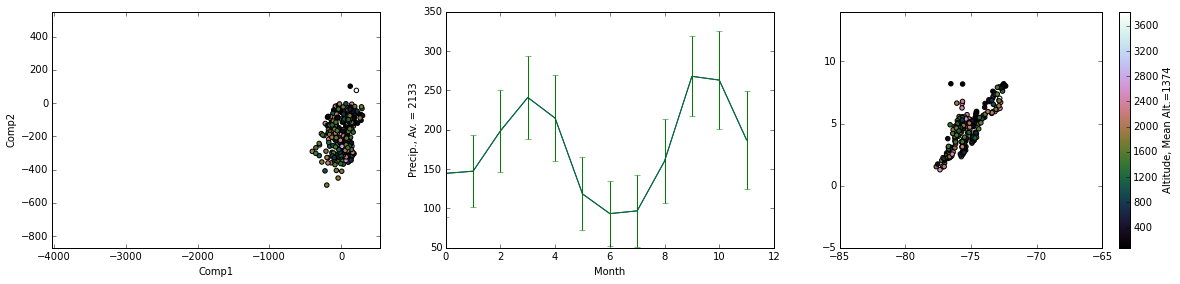

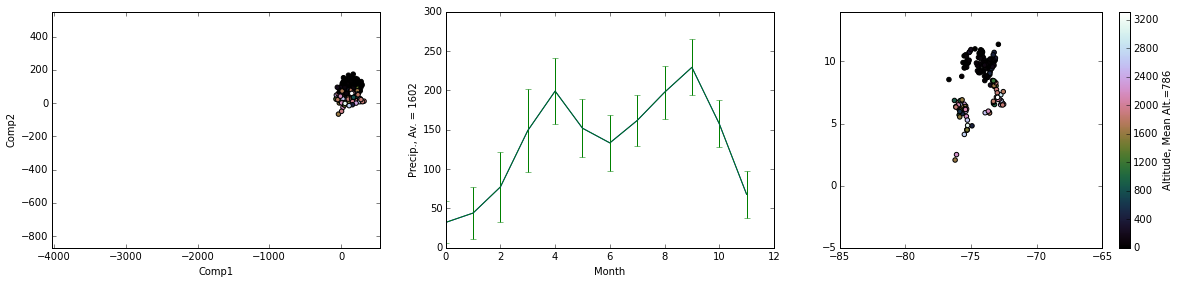

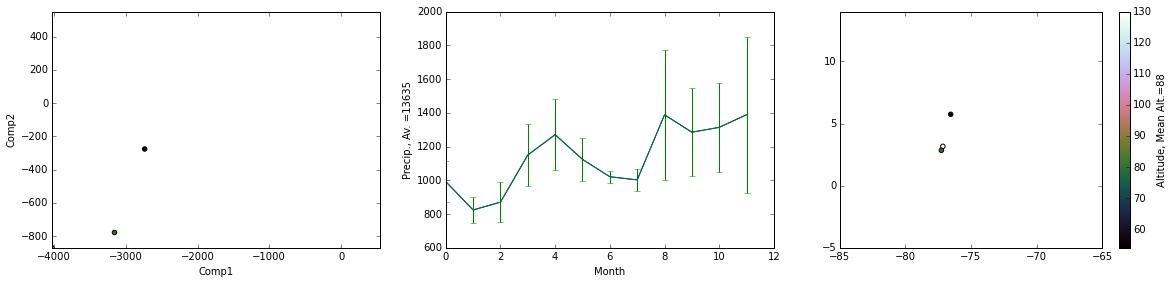

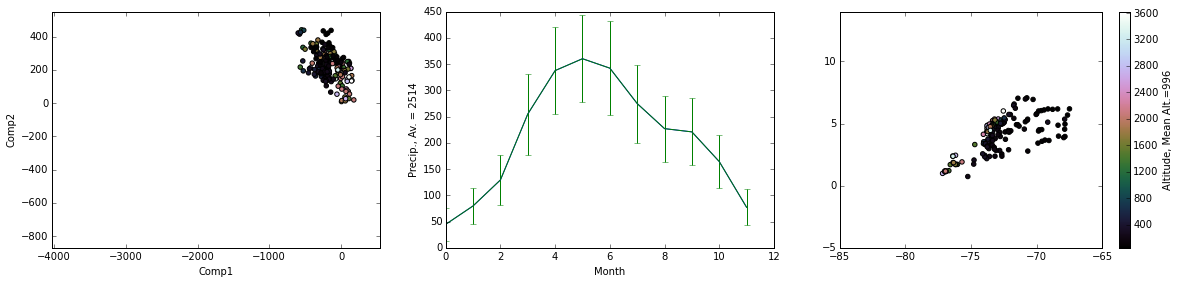

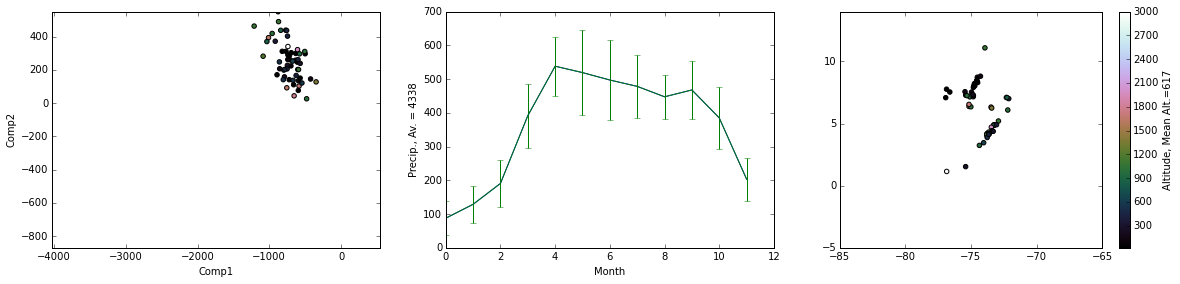

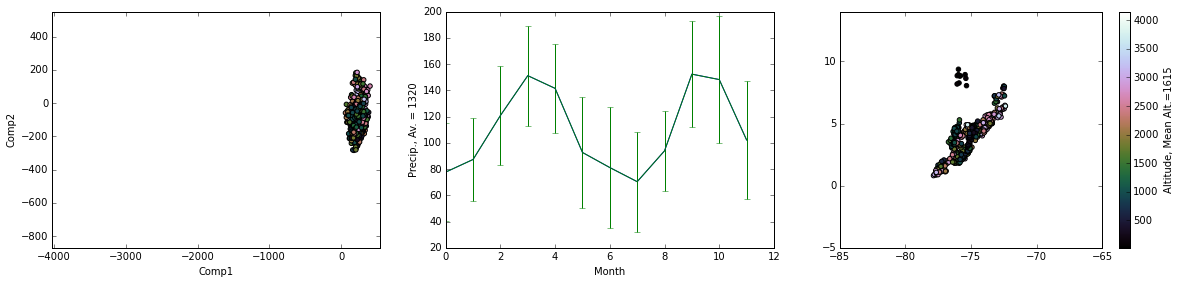

In [5]:
# ahora con lluvia, se requieren 3 componentes para cubrir >95% de varianza
df=pd.read_csv('lluvia.csv')
df.head()

# script que hace todo lo anterior, pero con lluvia, usando lluvia.csv

# Componentes principales
AL=df.as_matrix(columns=df.columns[8:20])
pca = PCA(0.95)  
XprojL = pca.fit_transform(AL)
print(AL.shape)
print(XprojL.shape)
print pca.explained_variance_ratio_.sum(axis=0)
print pca.explained_variance_ratio_
Ncomp = XprojL.shape[1]

# para que las gráficas se vean con los mismos ejes
xmin=min(XprojL[:, 0])
xmax=max(XprojL[:, 0])
ymin=min(XprojL[:, 1])
ymax=max(XprojL[:, 1])

# conversión de formato LATLON
latL=np.zeros(len(df.LATITUD))
lonL=np.zeros(len(df.LATITUD))
codeL=np.zeros(len(df.LATITUD))
for i in range(len(df.LATITUD)):
    latL[i]=conversion(df.LATITUD[i])
    lonL[i]=conversion(df.LONGITUD[i])
    codeL[i]=df.CODIGO[i]
    
# Mixtura gaussiana para kcomp clusters (4)
kcomp=11
gmm = GMM(kcomp, covariance_type='full', random_state=0)
gmm.fit(XprojL)
cluster_labelL = gmm.predict(XprojL)


# Se hace una gráfica para cada cluster
for kk in range(kcomp):
    D=np.zeros([sum(cluster_labelL==kk),Ncomp])
    B=np.zeros([sum(cluster_labelL==kk),12])
    LAT=np.zeros([sum(cluster_labelL==kk)])
    LON=np.zeros([sum(cluster_labelL==kk)])
    ALTL=np.zeros([sum(cluster_labelL==kk)])
    i=0
    for k in range(len(df)):
        if cluster_labelL[k]==kk:
            B[i]=AL[k]
            D[i]=XprojL[k]
            LAT[i]=latL[k]
            LON[i]=lonL[k]
            ALTL[i]=df.ELEV[k]
            i=i+1
    print "Number of stations in cluster %i is %i" %(kk,i)
    plt.figure(figsize=(20,5*kcomp))
    ii=0

#
    plt.subplot(kcomp, 3, ii+1)
    plt.scatter(D[:, 0], D[:, 1],c=ALTL,cmap='cubehelix')
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xlabel('Comp1')
    plt.ylabel('Comp2')

    xx=np.arange(12)
    plt.subplot(kcomp, 3, ii+2)
    plt.plot(B.mean(axis=0))
    plt.errorbar(xx,B.mean(axis=0),yerr=B.std(axis=0))
    plt.xlabel('Month')
    plt.ylabel('Precip., Av. =%5.f' % B.mean(axis=0).sum())

    plt.subplot(kcomp, 3, ii+3)
    plt.scatter(-LON,-LAT,c=ALTL,cmap='cubehelix')
    plt.colorbar(label='Altitude, Mean Alt.=%i' % ALTL.mean())
    plt.xlim(-85,-65)
    plt.ylim(-5,14)
    ii=ii+3
    

445


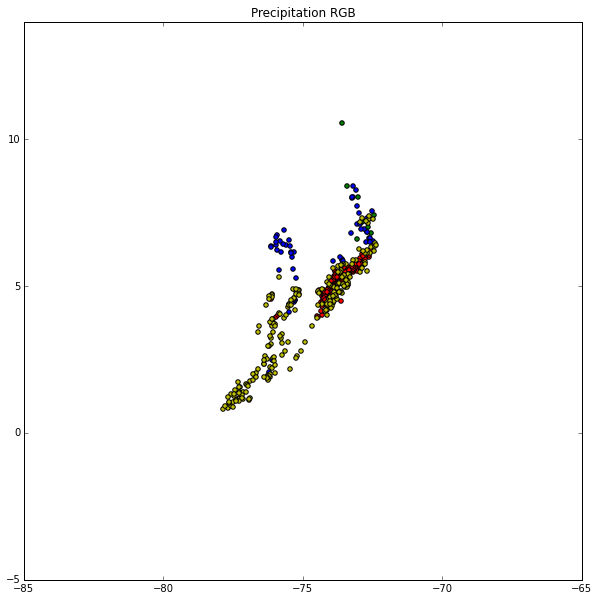

In [6]:
# Esto es para graficarlos todos en una misma gráfica de LATLON. Ahora LAT y LON son arrays
LATL=np.zeros([len(cluster_labelL),kcomp])
LONL=np.zeros([len(cluster_labelL),kcomp])
ALTL=np.zeros([len(cluster_labelL),kcomp])
CODL=np.zeros([len(cluster_labelL),kcomp])
for kk in range(kcomp):
    i=0
    for k in range(len(df)):
        if cluster_labelL[k]==kk:
            LATL[i,kk]=latL[k]
            LONL[i,kk]=lonL[k]
            ALTL[i,kk]=df.ELEV[k]
            CODL[i,kk]=df.CODIGO[k]
            i=i+1
# Graficamos 3 componentes al tiempo. Los puntos rojos son el primer cluster, el más interesante para nosotros
# Los siguientes importantes son el segundo cluster (verdes)
plt.figure(figsize=(10,10))
filter1=ALTL[:,1]>1500
filter4=ALTL[:,4]>1500
filter6=ALTL[:,6]>1500
filter10=ALTL[:,10]>1500
plt.scatter(-LONL[:,1][filter1],-LATL[:,1][filter1],c='r')
plt.scatter(-LONL[:,4][filter4],-LATL[:,4][filter4],c='g')
plt.scatter(-LONL[:,6][filter6],-LATL[:,6][filter6],c='b')
plt.scatter(-LONL[:,10][filter10],-LATL[:,10][filter10],c='y')
# Esta no porque pa que
#plt.scatter(-LON[:,3],-LAT[:,3],c='y')
plt.xlim(-85,-65)
plt.ylim(-5,14)
plt.title("Precipitation RGB")
print filter1.sum()+filter4.sum()+filter6.sum()+filter10.sum()

(2002, 12)
(2002, 3)
0.963298585519
[ 0.77041413  0.16628419  0.02660027]
Number of stations in cluster 0 is 359
Number of stations in cluster 1 is 244
Number of stations in cluster 2 is 444
Number of stations in cluster 3 is 348
Number of stations in cluster 4 is 278
Number of stations in cluster 5 is 329


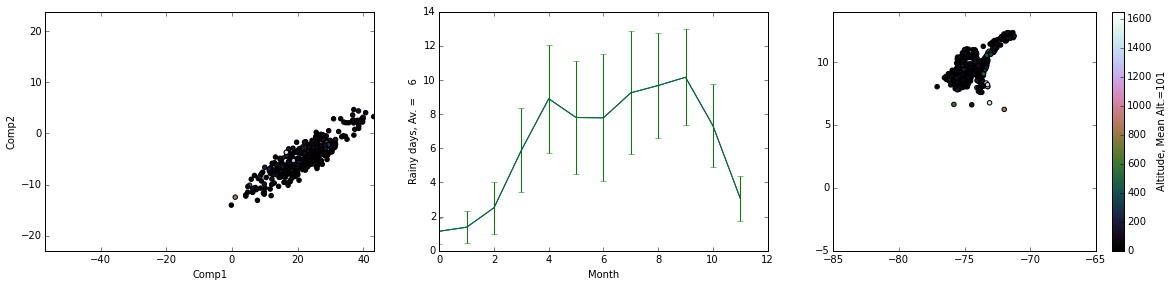

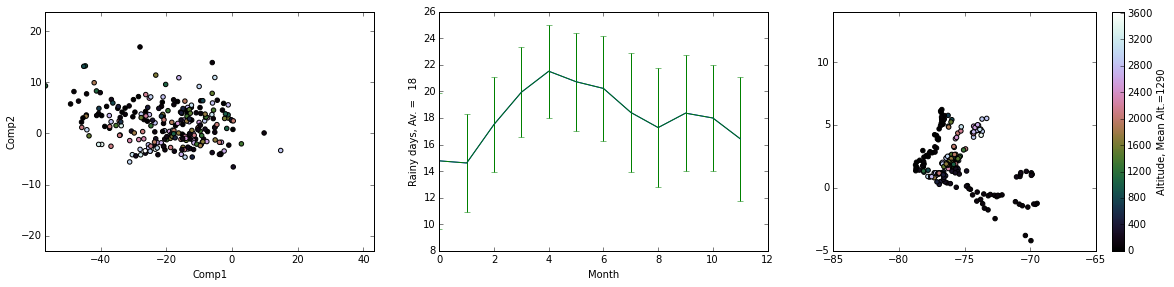

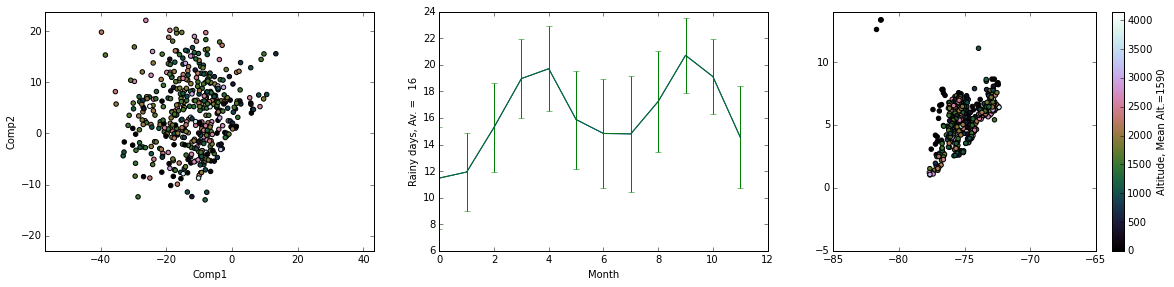

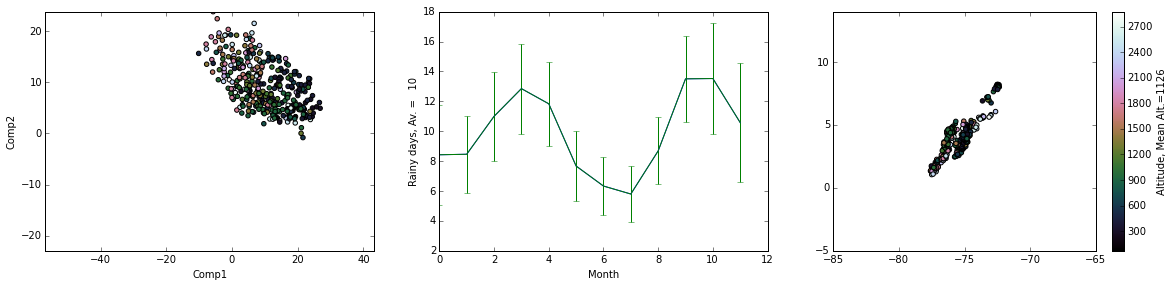

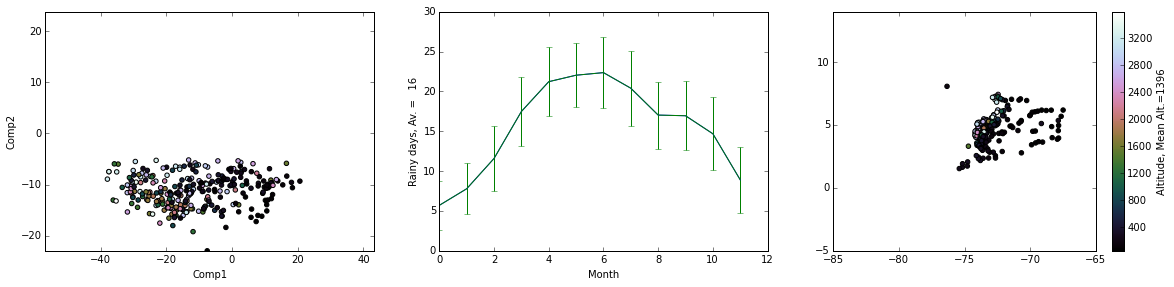

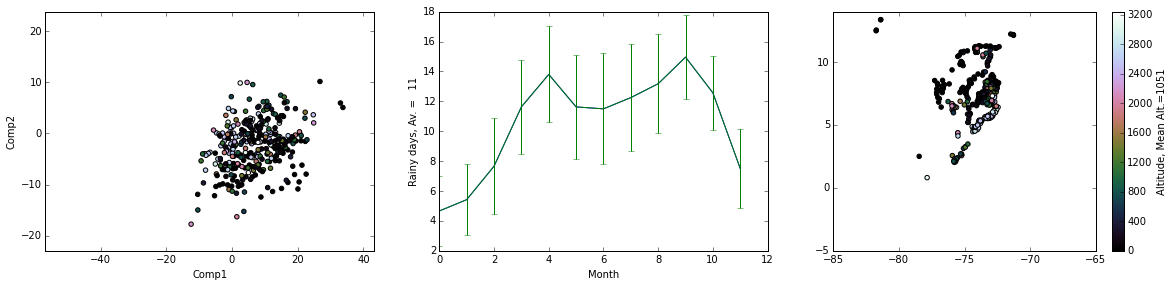

In [7]:
# ahora con días con lluvia, también toca con tres componentes
df=pd.read_csv('diaslluvia.csv')

#datos crudos mes a mes por estacion - días con lluvia de diaslluvia.csv
#AB=AD[np.isfinite(AD).prod(axis=1).astype(bool),:]
AD=df.as_matrix(columns=df.columns[8:20])
pca = PCA(0.95)  
XprojD = pca.fit_transform(AD)
print(AD.shape)
print(XprojD.shape)
print pca.explained_variance_ratio_.sum(axis=0)
print pca.explained_variance_ratio_
Ncomp = XprojD.shape[1]

# para que las gráficas se vean con los mismos ejes
xmin=min(XprojD[:, 0])
xmax=max(XprojD[:, 0])
ymin=min(XprojD[:, 1])
ymax=max(XprojD[:, 1])

# conversión de formato LATLON
latD=np.zeros(len(df.LATITUD))
lonD=np.zeros(len(df.LATITUD))
codeD=np.zeros(len(df.LATITUD))
for i in range(len(df.LATITUD)):
    latD[i]=conversion(df.LATITUD[i])
    lonD[i]=conversion(df.LONGITUD[i])
    codeD[i]=df.CODIGO[i]    
# Mixtura gaussiana para kcomp clusters
kcomp=6
gmm = GMM(kcomp, covariance_type='full', random_state=0)
gmm.fit(XprojD)
cluster_labelD = gmm.predict(XprojD)
#df['Cluster1'] = cluster_label

# Se hace una gráfica para cada cluster
for kk in range(kcomp):
    D=np.zeros([sum(cluster_labelD==kk),Ncomp])
    B=np.zeros([sum(cluster_labelD==kk),12])
    LAT=np.zeros([sum(cluster_labelD==kk)])
    LON=np.zeros([sum(cluster_labelD==kk)])
    ALT=np.zeros([sum(cluster_labelD==kk)])
    i=0
    for k in range(len(cluster_labelD)):
        if cluster_labelD[k]==kk:
            B[i]=AD[k]
            D[i]=XprojD[k]
            LAT[i]=latD[k]
            LON[i]=lonD[k]
            ALT[i]=df.ELEV[k]
            i=i+1
    print "Number of stations in cluster %i is %i" %(kk,i)
    plt.figure(figsize=(20,5*kcomp))
    ii=0

#
    plt.subplot(kcomp, 3, ii+1)
    plt.scatter(D[:, 0], D[:, 1],c=ALT,cmap='cubehelix')
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xlabel('Comp1')
    plt.ylabel('Comp2')

    xx=np.arange(12)
    plt.subplot(kcomp, 3, ii+2)
    plt.plot(B.mean(axis=0))
    plt.errorbar(xx,B.mean(axis=0),yerr=B.std(axis=0))
    plt.xlabel('Month')
    plt.ylabel('Rainy days, Av. =%5.f' % B.mean(axis=0).mean())

    plt.subplot(kcomp, 3, ii+3)
    plt.scatter(-LON,-LAT,c=ALT,cmap='cubehelix')
    plt.colorbar(label='Altitude, Mean Alt.=%i' % ALT.mean())
    plt.xlim(-85,-65)
    plt.ylim(-5,14)
    ii=ii+3
    

199


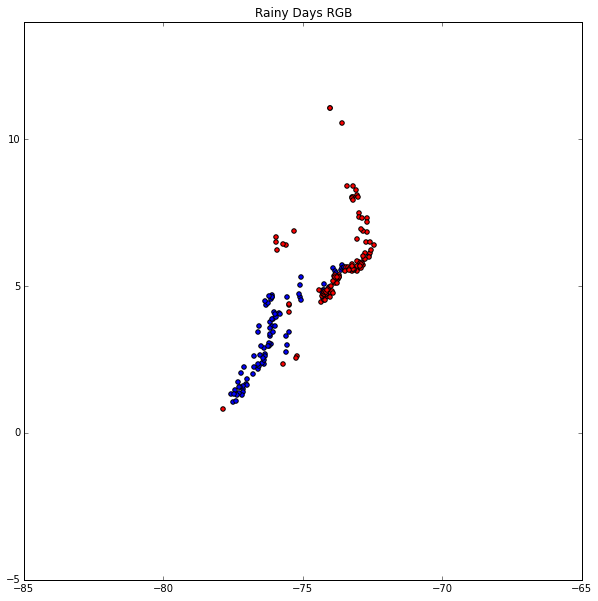

In [8]:
# Esto es para graficarlos todos en una misma gráfica de LATLON. Ahora LAT y LON son arrays
LATD=np.zeros([len(cluster_labelD),kcomp])
LOND=np.zeros([len(cluster_labelD),kcomp])
ALTD=np.zeros([len(cluster_labelD),kcomp])
CODD=np.zeros([len(cluster_labelD),kcomp])

for kk in range(kcomp):
    i=0
    for k in range(len(cluster_labelD)):
        if cluster_labelD[k]==kk:
            LATD[i,kk]=latD[k]
            LOND[i,kk]=lonD[k]
            ALTD[i,kk]=df.ELEV[k]
            CODD[i,kk]=df.CODIGO[k]
            i=i+1
# Graficamos 3 componentes al tiempo. Los puntos rojos son el primer cluster, el más interesante para nosotros
# El tercero también es interesante
# Lo otro que falta es hacer un clustering por LONLAT y altura sobre las estaciones que tengan las condiciones ideales
plt.figure(figsize=(10,10))

filter0=ALTD[:,0]>1500
filter3=ALTD[:,3]>1500
filter5=ALTD[:,5]>1500
plt.scatter(-LOND[:,0][filter0],-LATD[:,0][filter0],c='g')
plt.scatter(-LOND[:,3][filter3],-LATD[:,3][filter3],c='b')
plt.scatter(-LOND[:,5][filter5],-LATD[:,5][filter5],c='r')
# Esta no porque pa que
#plt.scatter(-LON[:,3],-LAT[:,3],c='y')
plt.xlim(-85,-65)
plt.ylim(-5,14)
plt.title('Rainy Days RGB')
# Hay que cambiar el orden, primero es 2, segundo es 0
print filter0.sum()+filter3.sum()+filter5.sum()

(336, 12)
(336, 3)
0.968881031972
[ 0.8163693   0.11928973  0.03322201]
3982.44755121
Number of stations in cluster 0 is 121
Number of stations in cluster 1 is 46
Number of stations in cluster 2 is 63
Number of stations in cluster 3 is 43
Number of stations in cluster 4 is 63


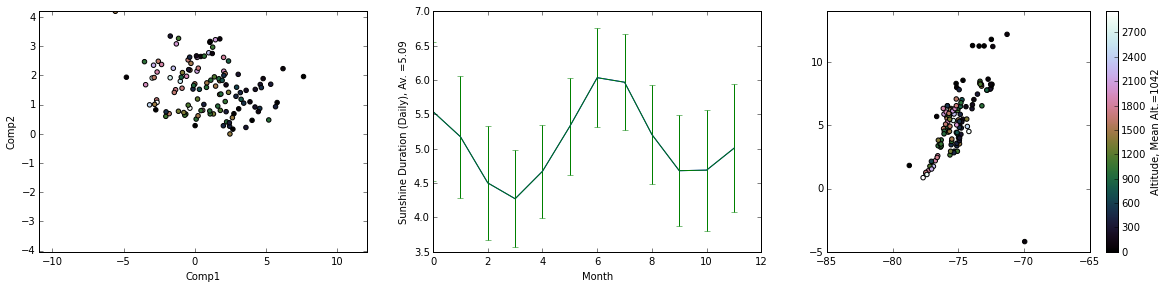

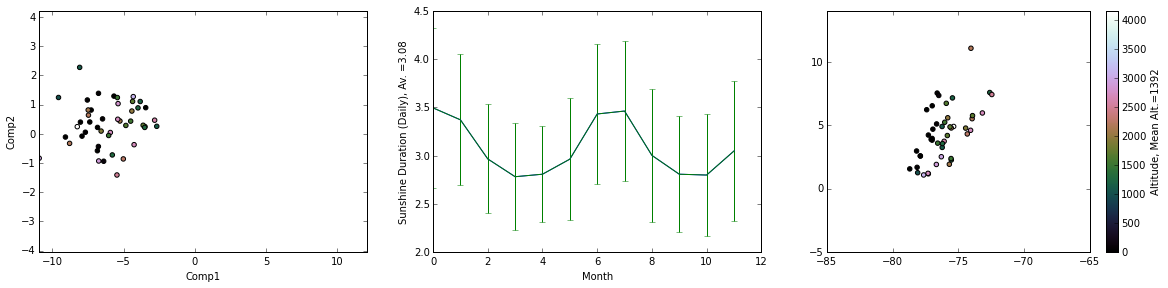

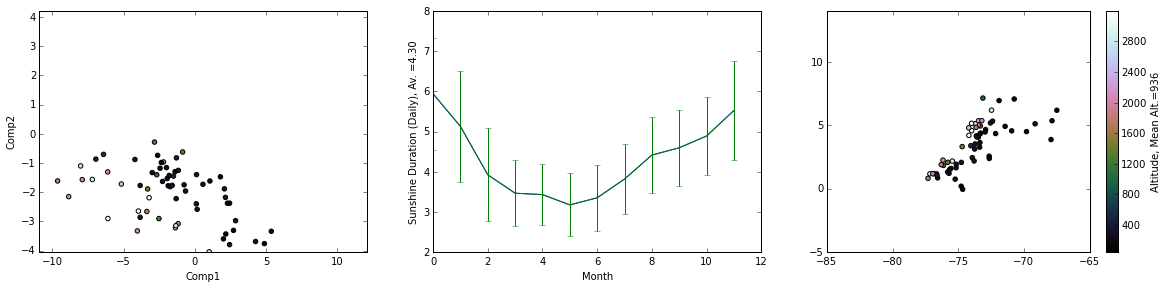

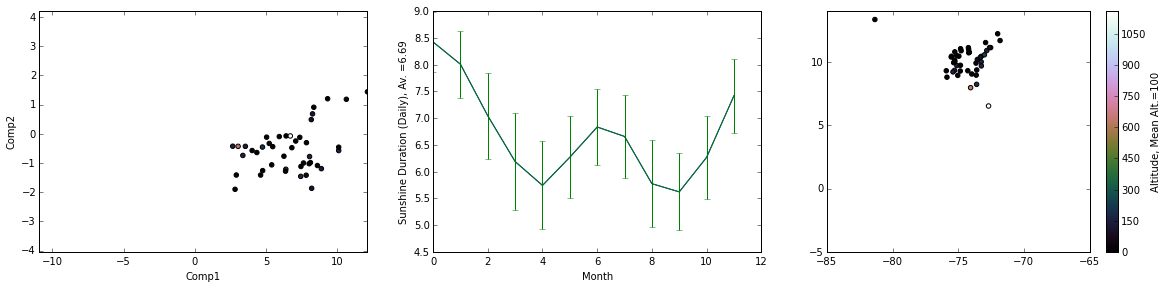

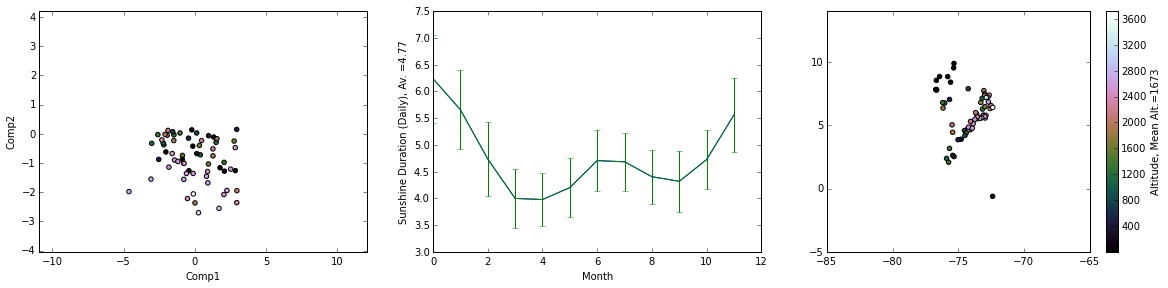

In [9]:
# ahora con brillo solar
df=pd.read_csv('brillo.csv')

#datos crudos mes a mes por estacion - brillo solar de brillo.csv
AB=df.as_matrix(columns=df.columns[8:20])
pca = PCA(0.95)  
XprojB = pca.fit_transform(AB)
print(AB.shape)
print(XprojB.shape)
print pca.explained_variance_ratio_.sum(axis=0)
print pca.explained_variance_ratio_
Ncomp = XprojB.shape[1]


# para que las gráficas se vean con los mismos ejes
xmin=min(XprojB[:, 0])
xmax=max(XprojB[:, 0])
ymin=min(XprojB[:, 1])
ymax=max(XprojB[:, 1])

# conversión de formato LATLON
latB=np.zeros(len(df.LATITUD))
lonB=np.zeros(len(df.LATITUD))
codeB=np.zeros(len(df.LATITUD))
for i in range(len(df.LATITUD)):
    latB[i]=conversion(df.LATITUD[i])
    lonB[i]=conversion(df.LONGITUD[i])
    codeB[i]=df.CODIGO[i]    
    
# Mixtura gaussiana para kcomp clusters
kcomp=5
gmm = GMM(kcomp, covariance_type='tied', random_state=0)
gmm.fit(XprojB)
print gmm.bic(XprojB)
cluster_labelB = gmm.predict(XprojB)
#df['Cluster1'] = cluster_label

# Se hace una gráfica para cada cluster
for kk in range(kcomp):
    D=np.zeros([sum(cluster_labelB==kk),Ncomp])
    B=np.zeros([sum(cluster_labelB==kk),12])
    LAT=np.zeros([sum(cluster_labelB==kk)])
    LON=np.zeros([sum(cluster_labelB==kk)])
    ALT=np.zeros([sum(cluster_labelB==kk)])
    i=0
    for k in range(len(cluster_labelB)):
        if cluster_labelB[k]==kk:
            B[i]=AB[k]
            D[i]=XprojB[k]
            LAT[i]=latB[k]
            LON[i]=lonB[k]
            ALT[i]=df.ELEV[k]
            i=i+1
    print "Number of stations in cluster %i is %i" %(kk,i)
    plt.figure(figsize=(20,5*kcomp))
    ii=0

#
    plt.subplot(kcomp, 3, ii+1)
    plt.scatter(D[:, 0], D[:, 1],c=ALT,cmap='cubehelix')
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xlabel('Comp1')
    plt.ylabel('Comp2')

    xx=np.arange(12)
    plt.subplot(kcomp, 3, ii+2)
    plt.plot(B.mean(axis=0))
    plt.errorbar(xx,B.mean(axis=0),yerr=B.std(axis=0))
    plt.xlabel('Month')
    plt.ylabel('Sunshine Duration (Daily), Av. =%.2f' % B.mean(axis=0).mean())

    plt.subplot(kcomp, 3, ii+3)
    plt.scatter(-LON,-LAT,c=ALT,cmap='cubehelix')
    plt.colorbar(label='Altitude, Mean Alt.=%i' % ALT.mean())
    plt.xlim(-85,-65)
    plt.ylim(-5,14)
    ii=ii+3
    

69


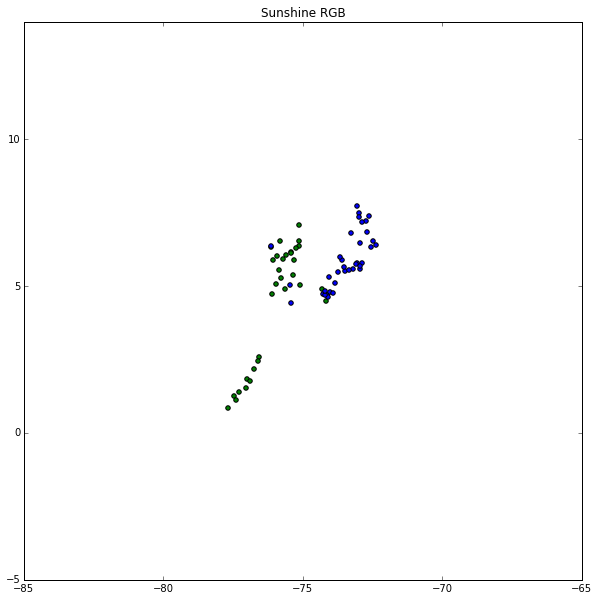

In [10]:
# Esto es para graficarlos todos en una misma gráfica de LATLON. Ahora LAT y LON son arrays
LATB=np.zeros([len(cluster_labelB),kcomp])
LONB=np.zeros([len(cluster_labelB),kcomp])
ALTB=np.zeros([len(cluster_labelB),kcomp])
CODB=np.zeros([len(cluster_labelB),kcomp])
for kk in range(kcomp):
    i=0
    for k in range(len(cluster_labelB)):
        if cluster_labelB[k]==kk:
            LATB[i,kk]=latB[k]
            LONB[i,kk]=lonB[k]
            ALTB[i,kk]=df.ELEV[k]
            CODB[i,kk]=df.CODIGO[k]
            i=i+1
# Graficamos 3 componentes al tiempo. Los puntos rojos son el segundo cluster, el más interesante para nosotros
# El cuarto también es interesante
# Lo otro que falta es hacer un clustering por LONLAT y altura sobre las estaciones que tengan las condiciones ideales
plt.figure(figsize=(10,10))
filter3=ALTB[:,3]>1500
filter4=ALTB[:,4]>1500

filter0=ALTB[:,0]>1500
plt.scatter(-LONB[:,0][filter0],-LATB[:,0][filter0],c='g')
#plt.scatter(-LONB[:,1],-LATB[:,1],c='y')
#plt.scatter(-LONB[:,3],-LATB[:,3],c='b')
# Esta no porque pa que
plt.scatter(-LONB[:,3][filter3],-LATB[:,3][filter3],c='r')
plt.scatter(-LONB[:,4][filter4],-LATB[:,4][filter4],c='b')

plt.xlim(-85,-65)
plt.ylim(-5,14)
plt.title('Sunshine RGB')
# principal: 2 secundario 0
print filter0.sum()+filter3.sum()+filter4.sum()

(-5, 14)

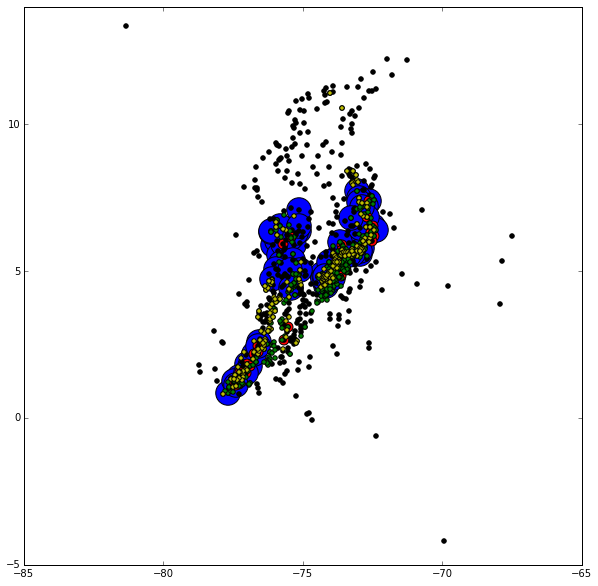

In [11]:
#Aplicamos el filtro de altura > 1500 msnm para cada grupo de interes para cada variable

plt.figure(figsize=(10,10))
filter3=ALTB[:,3]>1500
filter4=ALTB[:,4]>1500
filter0=ALTB[:,0]>1500
plt.scatter(-LONB[:,0][filter0],-LATB[:,0][filter0],c='b',s=600)
plt.scatter(-LONB[:,3][filter3],-LATB[:,3][filter3],c='b',s=600)
plt.scatter(-LONB[:,4][filter4],-LATB[:,4][filter4],c='b',s=600)

filter1=ALTH[:,1]>1500
plt.scatter(-LONH[:,1][filter1],-LATH[:,1][filter1],c='r',s=100)
plt.scatter(-LONH[:,1],-LATH[:,1],c='k')
plt.scatter(-LONH[:,0],-LATH[:,0],c='k')

filter1=ALTL[:,1]>1500
filter4=ALTL[:,4]>1500
filter6=ALTL[:,6]>1500
filter10=ALTL[:,10]>1500
plt.scatter(-LONL[:,1][filter1],-LATL[:,1][filter1],c='g')
plt.scatter(-LONL[:,4][filter4],-LATL[:,4][filter4],c='g')
plt.scatter(-LONL[:,6][filter6],-LATL[:,6][filter6],c='g')
plt.scatter(-LONL[:,10][filter10],-LATL[:,10][filter10],c='g')

filter0=ALTD[:,0]>1500
filter3=ALTD[:,3]>1500
filter5=ALTD[:,5]>1500
plt.scatter(-LOND[:,0][filter0],-LATD[:,0][filter0],c='y')
plt.scatter(-LOND[:,3][filter3],-LATD[:,3][filter3],c='y')
plt.scatter(-LOND[:,5][filter5],-LATD[:,5][filter5],c='y')

plt.xlim(-85,-65)
plt.ylim(-5,14)

In [12]:
# funcion que une los grupos de interes para cada variable, segun la clasificacion del modelo de mixtura gaussiana
# genera un arreglo con los datos "extraidos", p.ej. de todos los datos de precipitacion saco solo los que me interesan
# PP es una lista con los grupos que me interesan para cada variable
def stitch(PP,ALT,LON,LAT,COD):
    LN=np.array([])
    LT=np.array([])
    CD=np.array([])
    AT=np.array([])
    for i in PP:
        filter=ALT[:,i]>1500
        LN=np.hstack((LN,LON[:,i][(LON[:,i]!=0)*(filter)]))
        LT=np.hstack((LT,LAT[:,i][(LAT[:,i]!=0)*(filter)]))
        CD=np.hstack((CD,COD[:,i][(COD[:,i]!=0)*(filter)]))
        AT=np.hstack((AT,ALT[:,i][(ALT[:,i]!=0)*(filter)]))
    return np.vstack((CD,LN,LT,AT)).T

In [13]:
# Aqui usamos la funcion anterior, PP le indica a la funcion cuales grupos me interesan
PP=[0,3,4]
DATB=stitch(PP,ALTB,LONB,LATB,CODB)
PP=[1]
DATH=stitch(PP,ALTH,LONH,LATH,CODH)
PP=[1,4,6,10]
DATL=stitch(PP,ALTL,LONL,LATL,CODL)
PP=[0,3,5]
DATD=stitch(PP,ALTD,LOND,LATD,CODD)

In [14]:
# Se unen todas las variables en un solo arreglo, nos quedamos con 751 datos (hay repetidos)
# En este arreglo estan todos los datos que cumplen por lo menos uno de los criterios, y quedan a mas de 1500 msnm
# 0=codigo, 1,2=lonlat, 3=altura (segun la funcion stitch)
DATT=np.vstack((DATB,DATH,DATL,DATD))
np.savetxt('datos.txt',DATT)
# Luego unificamos con las estaciones que cumplen al menos un criterio

In [15]:
%%bash
awk '{print $0}' datos.txt | sort -n | uniq -c > listam.txt
rm datos.txt

In [16]:
# Ahora seleccionamos los que cumplen al menos 1 de 3 criterios: humedad, lluvia, y dias con lluvia
DAT3C=np.vstack((DATH,DATL,DATD))
np.savetxt('datos3c.txt',DAT3C)

In [17]:
%%bash
awk '{print $0}' datos3c.txt | sort -n | uniq -c > listam3c.txt
rm datos3c.txt

In [18]:
# generamos una lista con las estaciones que cumplen 1 de 3 criterios, y contamos cuantos de ellos son cumplidos
listam3c=np.loadtxt('listam3c.txt')

In [19]:
# contamos cuantas variables (humedad, lluvia, y dias con lluvia) fueron medidas
df=pd.read_csv('lluvia.csv')
tomados3c=np.zeros(len(listam3c[:,1]))
for i in range(len(listam3c[:,1])):
    for k in range(len(df.CODIGO)):
        if(listam3c[i,1]==df.CODIGO[k]):
            tomados3c[i]+=1
df=pd.read_csv('humedad.csv')
for i in range(len(listam3c[:,1])):
    for k in range(len(df.CODIGO)):
        if(listam3c[i,1]==df.CODIGO[k]):
            tomados3c[i]+=1
df=pd.read_csv('diaslluvia.csv')
for i in range(len(listam3c[:,1])):
    for k in range(len(df.CODIGO)):
        if(listam3c[i,1]==df.CODIGO[k]):
            tomados3c[i]+=1  

In [51]:
# filtramos las que cumplen o pueden cumplir los 3 criterios (es decir, considerando los casos en los que no se midieron algunos de las variables)
pfilter3c=tomados3c-listam3c[:,0]==0
listacorta3c=listam3c[pfilter3c]

In [71]:
# encontramos las estaciones en listacorta3c en las que se tomaron datos de brillo solar
df=pd.read_csv('brillo.csv')
tomados3cB=np.zeros(len(listacorta3c[:,1]))
for i in range(len(listacorta3c[:,1])):
    for k in range(len(df.CODIGO)):
        if(listacorta3c[i,1]==df.CODIGO[k]):
            tomados3cB[i]+=1 

In [72]:
# encontramos las estaciones en listacorta3c que cumplen el criterio de brillo solar
cbrillo3cB=np.zeros(len(listacorta3c[:,1]))
for i in range(len(listacorta3c[:,1])):
    for k in range(len(DATB[:,1])):
        if(listacorta3c[i,1]==DATB[k,0]):
            cbrillo3cB[i]+=1 

In [75]:
# 0=no cumple el criterio de brillo solar, 1=si lo cumple, 2=no fue medido
Brillo=2*(1-tomados3cB)+cbrillo3cB

In [163]:
Brillo[listacorta3c[:,0]==3]

array([ 1.,  1.,  1.,  1.,  1.,  2.])

In [89]:
# tabla de probabilidad (peso) para 3 variables que pueden o no cumplir criterios
def genprob3(cumple):
    if(cumple==3.):
        return 1./8
    if(cumple==2.):
        return (3./8)*(1./4)
    if(cumple==1.):
        return (3./8)*(1./7)

In [90]:
# se multiplica la anterior tabla con la tabla de probabilidad (peso) para el criterio de brillo 
# (casos de 12-24 horas de cielos despejados)
def parseprob3(cumple,brillo):
    if(brillo==2.):
        return genprob3(cumple)*3./4
    if(brillo==1.):
        return genprob3(cumple)*1.
    if(brillo==0.):
        return genprob3(cumple)*1./2

In [91]:
# genera un arreglo con pesos para cada estación
probarr12=np.zeros(len(Brillo))
for i in range(len(Brillo)):
    probarr12[i]=parseprob3(listacorta3c[i,0],Brillo[i])

In [181]:
colvec=np.loadtxt('colvecdep.txt')

(-5, 14)

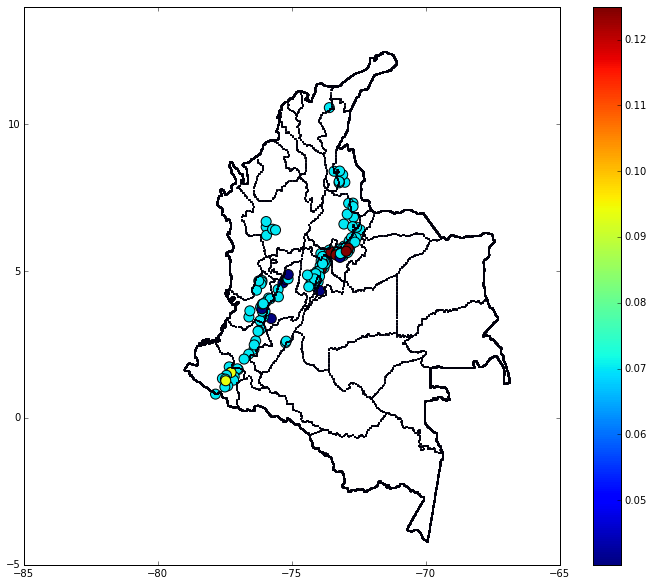

In [214]:
# peso estadístico para cada estación en listacorta3c
plt.figure(figsize=(12,10))
plt.scatter(-listacorta3c[:,2],-listacorta3c[:,3],c=probarr12,s=100)
plt.colorbar()
plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.xlim(-85,-65)
plt.ylim(-5,14)

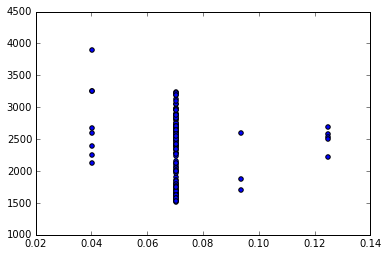

In [104]:
# distribución de pesos est. vs. altura
plt.scatter(probarr12,listacorta3c[:,4])

In [106]:
# generación de lista expandida que incluye pesos enteros para cada estación
lendata12=(probarr12*112*8).sum().astype(int)
wdata12=(probarr12*112*8).astype(int)
listaexp12=np.zeros((lendata12,5))
kcount=0
for i in range(len(probarr12)):        
    for kinx in range(wdata12[i]):
        listaexp12[kinx+kcount,:]=listacorta3c[i,:]
    kcount=kcount+kinx+1   

In [107]:
# clustering por mixtura gaussiana de la lista expandida, buscando un mínimo local para el criterio de información bayesiano
# el agrupamiento se hace por lon,lat,alt
cv_types = ['spherical', 'tied', 'diag', 'full']
bicold=0
for cv_type in cv_types:
    for kcomp in np.arange(90)+1:        
        gmm = GMM(kcomp, covariance_type=cv_type, random_state=0)
        gmm.fit(listaexp12[:,2:5])
#        if bicold<gmm.bic(listaexp12[:,2:5]):
        print cv_type,kcomp,gmm.bic(listaexp12[:,2:5])
        bicold=gmm.bic(listaexp12[:,2:5])

spherical 1 413662.315325
spherical 2 384729.296532
spherical 3 366233.938157
spherical 4 353250.307305
spherical 5 348494.793161
spherical 6 342094.041029
spherical 7 330904.02664
spherical 8 325129.210661
spherical 9 320068.912151
spherical 10 310656.179963
spherical 11 307913.769273
spherical 12 303721.937227
spherical 13 301383.390919
spherical 14 297361.036406
spherical 15 294766.144197
spherical 16 292143.991453
spherical 17 288665.878451
spherical 18 285113.275932
spherical 19 282729.206306
spherical 20 278839.479777
spherical 21 274496.957435
spherical 22 272671.193274
spherical 23 265507.325261
spherical 24 265239.069793
spherical 25 266106.002989
spherical 26 263074.104327
spherical 27 262597.095162
spherical 28 257951.697883
spherical 29 254951.360204
spherical 30 251960.530876
spherical 31 249223.829962
spherical 32 246479.772351
spherical 33 246359.523962
spherical 34 240622.659023
spherical 35 242205.452261
spherical 36 237037.395544
spherical 37 234677.022497
spherical 3

(150000, 240000)

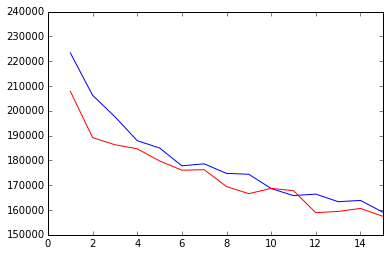

In [115]:
# encontramos un mínimo local para el BIC para el método 'full' para 7 componentes
gmmtext=np.loadtxt('gmm.txt')
plt.plot(gmmtext[:,0],gmmtext[:,1])
plt.plot(gmmtext[:,0],gmmtext[:,2],c='r')
plt.xlim(0,15)
plt.ylim(150000,240000)
# 6!,9,12, full

In [108]:
# re-escalamos los datos para darle más importancia al agrupamiento por alturas (similares pisos térmicos)
# el agrupamiento se hace por lon,lat,alt
from sklearn import preprocessing
X_scaled = preprocessing.scale(listaexp12[:,2:5])

In [222]:
# clustering por mixtura gaussiana de la lista expandida, buscando un mínimo local para el criterio de información bayesiano
# el agrupamiento se hace por lon,lat,alt
# para los datos re-escalados
cv_types = ['diag','full']
bicold=0
for cv_type in cv_types:
    for kcomp in np.arange(90)+1:        
        gmm = GMM(kcomp, covariance_type=cv_type, random_state=0)
        gmm.fit(X_scaled[:,2:5])
        print cv_type,kcomp,gmm.bic(X_scaled[:,2:5])

diag 1 27991.3510398
diag 2 25058.8525931
diag 3 23180.5182549
diag 4 23212.1189081
diag 5 23233.5980519
diag 6 23084.5792863
diag 7 23112.2617975
diag 8 23108.9626238
diag 9 23099.1376667
diag 10 23140.9235465
diag 11 23166.4557549
diag 12 23205.4192244
diag 13 23215.4693588
diag 14 23225.9753607
diag 15 23227.4126044
diag 16 23257.0918388
diag 17 23280.9762522
diag 18 23305.7695049
diag 19 23338.6904021
diag 20 23368.5972174
diag 21 23376.4753988
diag 22 23110.2950595
diag 23 23174.4794161
diag 24 23180.2383212
diag 25 23193.5881753
diag 26 23257.5210634
diag 27 23281.7287902
diag 28 23307.4074188
diag 29 23334.3922143
diag 30 23394.2158178
diag 31 23416.2659562
diag 32 23437.1071391
diag 33 23466.654349
diag 34 23488.5375055
diag 35 23518.3623391
diag 36 23552.3461882
diag 37 23572.6339775
diag 38 23600.9760599
diag 39 23625.4831234
diag 40 23676.3221832
diag 41 23675.0239583
diag 42 23699.9720432
diag 43 23755.6177951
diag 44 23755.1265424
diag 45 23815.384586
diag 46 23836.6048179

(23000, 24000)

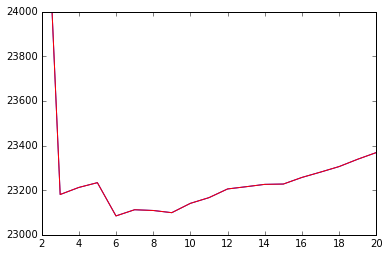

In [233]:
# encontramos dos mínimos locales para el BIC para el método 'full' para 6 componentes
gmmsctext=np.loadtxt('gmmsc.txt')
plt.plot(gmmsctext[:,0],gmmsctext[:,1])
plt.plot(gmmsctext[:,0],gmmsctext[:,2],c='r')
plt.xlim(2,20)
plt.ylim(23000,24000)
#11, full

In [189]:
# para los datos sin re-escalar, agrupamiento por mixtura gaussiana de 6 componentes
kcomp=6
gmm = GMM(kcomp, covariance_type='full', random_state=0)
gmm.fit(listaexp12[:,2:5])
cluster_label_stacked12 = gmm.predict(listaexp12[:,2:5])
print kcomp, gmm.bic(listaexp12[:,2:5])
# se almacenan los datos para procesarlos con bash con el fin de colapsar la lista expandida
listastacked12=np.vstack((listaexp12.T,cluster_label_stacked12)).T
np.savetxt('lisstck12.txt',listastacked12)

6 176050.486359


In [190]:
%%bash
uniq -c lisstck12.txt > listcomp12.txt
rm lisstck12.txt

<matplotlib.colorbar.Colorbar instance at 0x7fd276a36bd8>

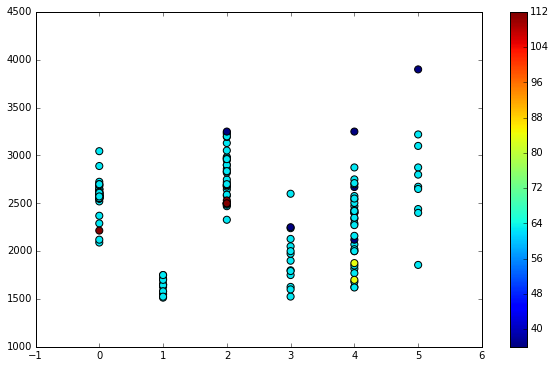

In [191]:
# distribución de grupos vs. altura vs. pesos estadísticos
listcomp12=np.loadtxt('listcomp12.txt')
plt.figure(figsize=(10,6))
plt.scatter(listcomp12[:,6],listcomp12[:,5],c=probarr12*112*8,s=50)
plt.colorbar()

(-5, 14)

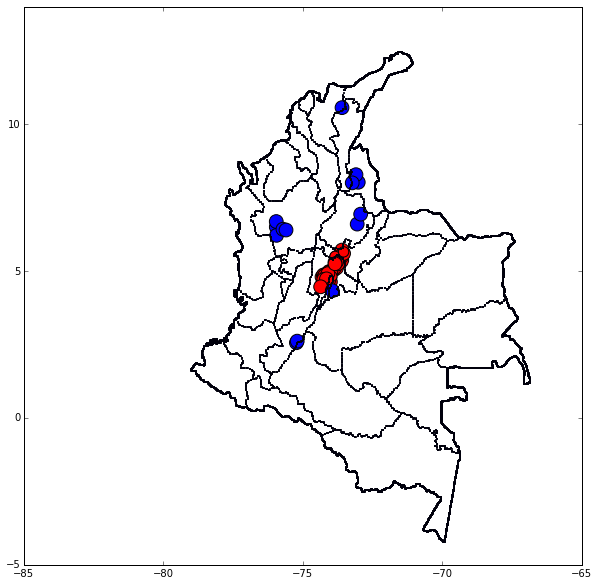

In [192]:
# clusters favoritos (encima de 2000 metros) son 0,2
plt.figure(figsize=(10,10))
#filter=(np.ones(len(listcomp12[:,6]))).astype(bool)
#listcomp12[:,6][filter]
filter=(listcomp12[:,6]==0)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='r',s=probarr12*112*8*3)
filter=(listcomp12[:,6]==3)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='b',s=probarr12*112*8*3)
plt.scatter(colvec[:,0],colvec[:,1],s=1)

#plt.colorbar()
plt.xlim(-85,-65)
plt.ylim(-5,14)

In [193]:
# para los datos sin re-escalar, agrupamiento por mixtura gaussiana de 9 componentes
kcomp=9
gmm = GMM(kcomp, covariance_type='full', random_state=0)
gmm.fit(listaexp12[:,2:5])
cluster_label_stacked12 = gmm.predict(listaexp12[:,2:5])
print kcomp, gmm.bic(listaexp12[:,2:5])
# se almacenan los datos para procesarlos con bash con el fin de colapsar la lista expandida
listastacked12=np.vstack((listaexp12.T,cluster_label_stacked12)).T
np.savetxt('lisstck12.txt',listastacked12)

9 166579.301452


In [194]:
%%bash
uniq -c lisstck12.txt > listcomp12.txt
rm lisstck12.txt

<matplotlib.colorbar.Colorbar instance at 0x7fd278a38758>

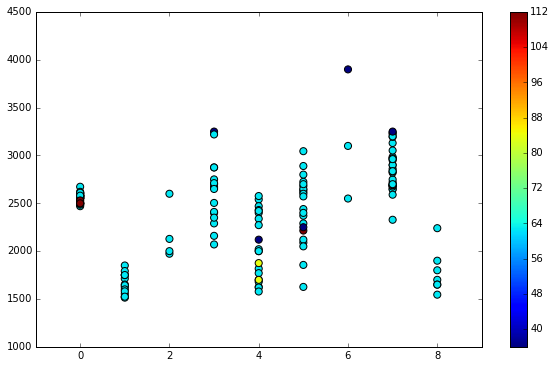

In [195]:
# distribución de grupos vs. altura vs. pesos estadísticos
listcomp12=np.loadtxt('listcomp12.txt')
plt.figure(figsize=(10,6))
plt.scatter(listcomp12[:,6],listcomp12[:,5],c=probarr12*112*8,s=50)
plt.colorbar()

(-5, 14)

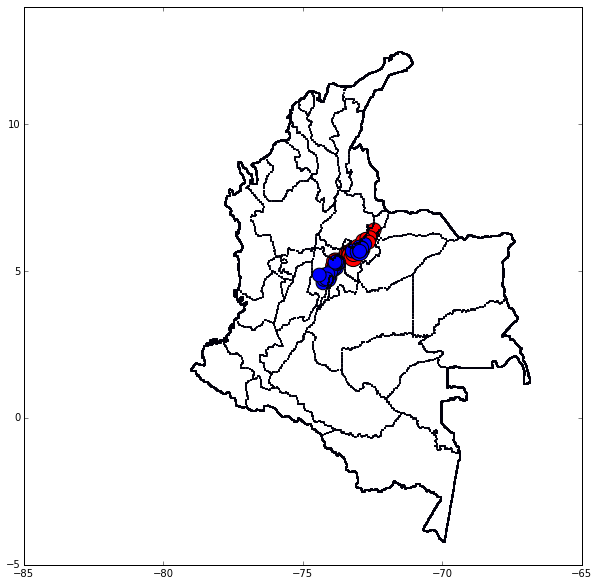

In [196]:
# clusters favoritos (encima de 2500 metros) son 
plt.figure(figsize=(10,10))
#filter=(np.ones(len(listcomp12[:,6]))).astype(bool)
#listcomp12[:,6][filter]
filter=(listcomp12[:,6]==7)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='r',s=probarr12*112*8*3)
filter=(listcomp12[:,6]==0)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='b',s=probarr12*112*8*3)
plt.scatter(colvec[:,0],colvec[:,1],s=1)
#plt.colorbar()
plt.xlim(-85,-65)
plt.ylim(-5,14)

In [210]:
# para los datos sin re-escalar, agrupamiento por mixtura gaussiana de 9 componentes
kcomp=12
gmm = GMM(kcomp, covariance_type='full', random_state=0)
gmm.fit(listaexp12[:,2:5])
cluster_label_stacked12 = gmm.predict(listaexp12[:,2:5])
print kcomp, gmm.bic(listaexp12[:,2:5])
# se almacenan los datos para procesarlos con bash con el fin de colapsar la lista expandida
listastacked12=np.vstack((listaexp12.T,cluster_label_stacked12)).T
np.savetxt('lisstck12.txt',listastacked12)

12 158935.233108


In [211]:
%%bash
uniq -c lisstck12.txt > listcomp12.txt
rm lisstck12.txt

<matplotlib.colorbar.Colorbar instance at 0x7fd2789f7a28>

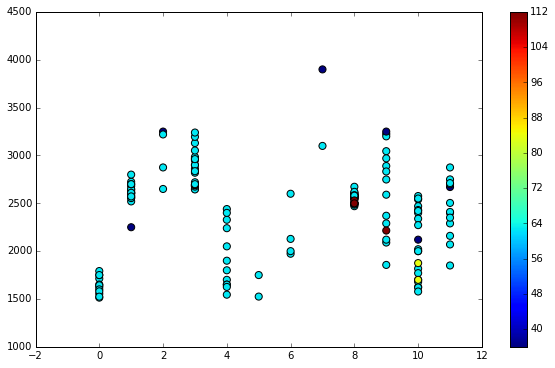

In [212]:
# distribución de grupos vs. altura vs. pesos estadísticos
listcomp12=np.loadtxt('listcomp12.txt')
plt.figure(figsize=(10,6))
plt.scatter(listcomp12[:,6],listcomp12[:,5],c=probarr12*112*8,s=50)
plt.colorbar()

(-5, 14)

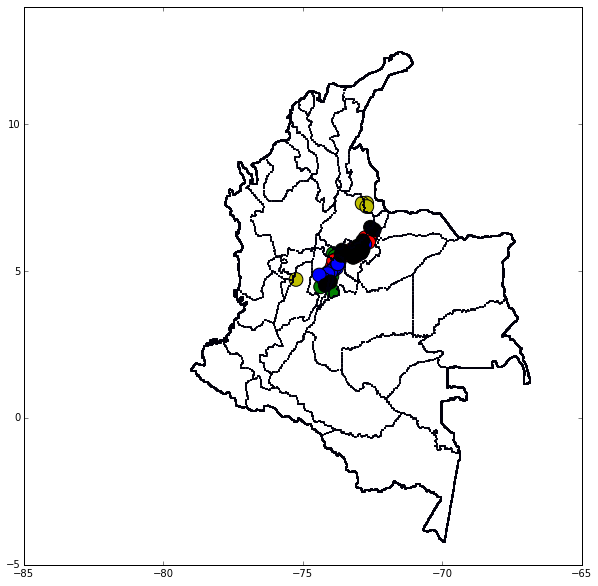

In [213]:
# clusters favoritos (encima de 2500 metros) son 
plt.figure(figsize=(10,10))
#filter=(np.ones(len(listcomp12[:,6]))).astype(bool)
#listcomp12[:,6][filter]
filter=(listcomp12[:,6]==1)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='g',s=probarr12*112*8*3)
filter=(listcomp12[:,6]==2)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='y',s=probarr12*112*8*3)
filter=(listcomp12[:,6]==3)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='r',s=probarr12*112*8*3)
filter=(listcomp12[:,6]==8)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='b',s=probarr12*112*8*3)
filter=(listcomp12[:,6]==9)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='k',s=probarr12*112*8*3)
plt.scatter(colvec[:,0],colvec[:,1],s=1)
#plt.colorbar()
plt.xlim(-85,-65)
plt.ylim(-5,14)

[  1.  10.]


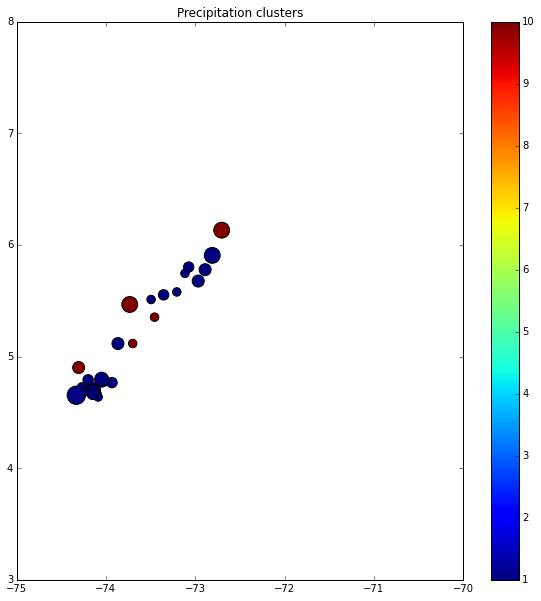

In [133]:
# clusters favoritos (encima de 2500 metros) son 0 cordillera oriental y 6 macizo colombiano
plt.figure(figsize=(10,10))
filter=(listcomp12[:,6]==0)
list12label=np.zeros(len(listcomp12[filter]))
for i in range(len(listcomp12[filter])):
    if((codeL==listcomp12[filter][i,2]).sum()==1):
        list12label[i]=cluster_labelL[codeL==listcomp12[filter][i,2]][0]
print np.unique(list12label)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c=list12label,s=probarr12*112*8*3)
plt.colorbar()
plt.xlim(-75,-70)
plt.ylim(3,8)
plt.title("Precipitation clusters")

[  1.  10.]


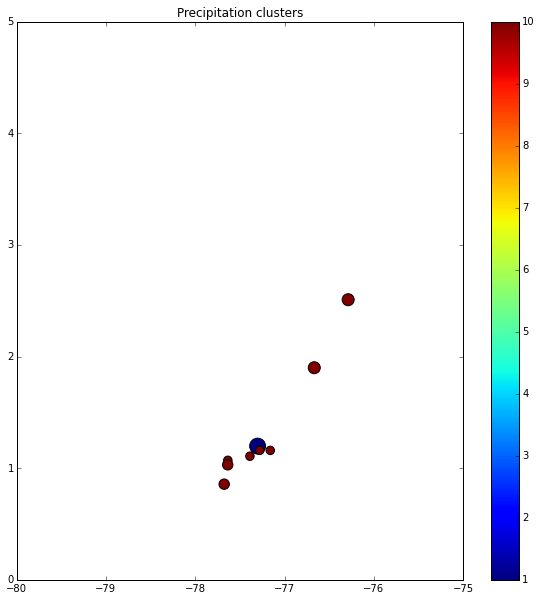

In [132]:
# clusters favoritos (encima de 2500 metros) son 0 cordillera oriental y 6 macizo colombiano
plt.figure(figsize=(10,10))
filter=(listcomp12[:,6]==6)
list12label=np.zeros(len(listcomp12[filter]))
for i in range(len(listcomp12[filter])):
    if((codeL==listcomp12[filter][i,2]).sum()==1):
        list12label[i]=cluster_labelL[codeL==listcomp12[filter][i,2]][0]
print np.unique(list12label)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c=list12label,s=probarr12*112*8*3)
plt.colorbar()
plt.xlim(-80,-75)
plt.ylim(0,5)
plt.title("Precipitation clusters")

[ 1.  2.  4.  5.]


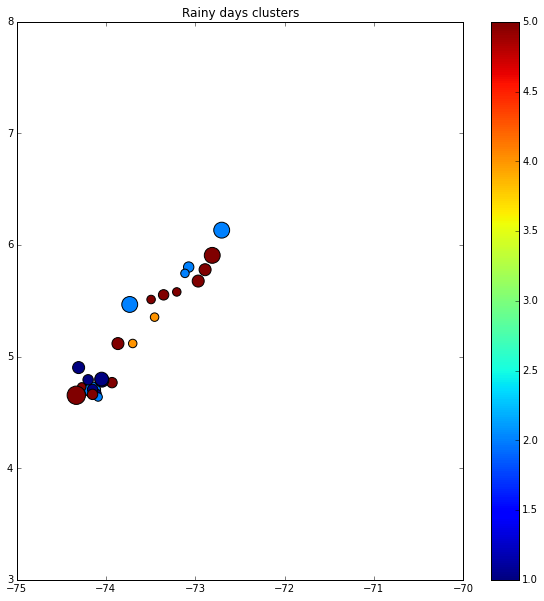

In [134]:
# clusters favoritos (encima de 2500 metros) son 0 cordillera oriental y 6 macizo colombiano
plt.figure(figsize=(10,10))
filter=(listcomp12[:,6]==0)
list12label=np.zeros(len(listcomp12[filter]))
for i in range(len(listcomp12[filter])):
    if((codeD==listcomp12[filter][i,2]).sum()==1):
        list12label[i]=cluster_labelD[codeD==listcomp12[filter][i,2]][0]
print np.unique(list12label)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c=list12label,s=probarr12*112*8*3)
plt.colorbar()
plt.xlim(-75,-70)
plt.ylim(3,8)
plt.title("Rainy days clusters")

[ 1.  2.]


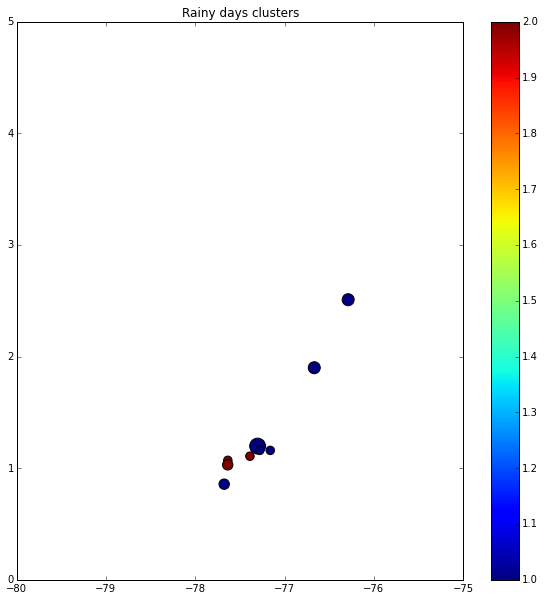

In [135]:
# clusters favoritos (encima de 2500 metros) son 0 cordillera oriental y 6 macizo colombiano
plt.figure(figsize=(10,10))
filter=(listcomp12[:,6]==6)
list12label=np.zeros(len(listcomp12[filter]))
for i in range(len(listcomp12[filter])):
    if((codeD==listcomp12[filter][i,2]).sum()==1):
        list12label[i]=cluster_labelD[codeD==listcomp12[filter][i,2]][0]
print np.unique(list12label)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c=list12label,s=probarr12*112*8*3)
plt.colorbar()
plt.xlim(-80,-75)
plt.ylim(0,5)
plt.title("Rainy days clusters")

In [234]:
# para los datos re-escalados, agrupamiento por mixtura gaussiana de 6 componentes
kcomp=6
gmm = GMM(kcomp, covariance_type='full', random_state=0)
gmm.fit(X_scaled[:,2:5])
cluster_label_stacked12sc = gmm.predict(X_scaled[:,2:5])
print kcomp, gmm.bic(X_scaled[:,2:5])
# se almacenan los datos para procesarlos con bash con el fin de colapsar la lista expandida
listastacked12sc=np.vstack((listaexp12.T,cluster_label_stacked12sc)).T
np.savetxt('lisstck12sc.txt',listastacked12sc)

6 23084.5792863


In [235]:
%%bash
uniq -c lisstck12sc.txt > listcomp12sc.txt
rm lisstck12sc.txt

(0, 4500.0)

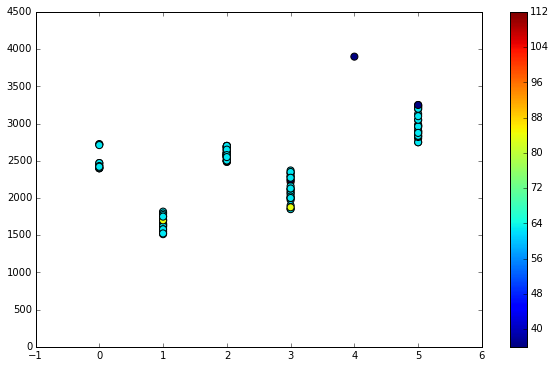

In [236]:
# distribución de grupos vs. altura vs. pesos estadísticos
listcomp12sc=np.loadtxt('listcomp12sc.txt')
plt.figure(figsize=(10,6))
plt.scatter(listcomp12sc[:,6],listcomp12sc[:,5],c=probarr12*112*8,s=50)
plt.colorbar()
plt.ylim(0)

(-5, 14)

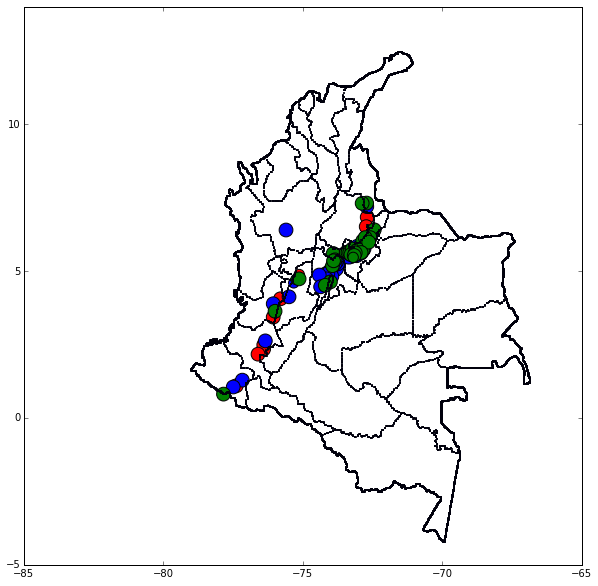

In [242]:
# clusters favoritos (encima de 2500 metros) son 1 cordillera oriental y 6 macizo colombiano
plt.figure(figsize=(10,10))
#filter=(np.ones(len(listcomp12[:,6]))).astype(bool)
filter=(listcomp12sc[:,6]==0)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='r',s=probarr12[filter]*112*8*3)
filter=(listcomp12sc[:,6]==2)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='b',s=probarr12[filter]*112*8*3)
filter=(listcomp12sc[:,6]==5)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='g',s=probarr12[filter]*112*8*3)
plt.scatter(colvec[:,0],colvec[:,1],s=1)

plt.xlim(-85,-65)
plt.ylim(-5,14)

In [205]:
# para los datos re-escalados, agrupamiento por mixtura gaussiana de 11 componentes
kcomp=11
gmm = GMM(kcomp, covariance_type='full', random_state=0)
gmm.fit(X_scaled)
cluster_label_stacked12sc = gmm.predict(X_scaled)
print kcomp, gmm.bic(X_scaled)
listastacked12sc=np.vstack((listaexp12.T,cluster_label_stacked12sc)).T
np.savetxt('lisstck12sc.txt',listastacked12sc)

11 20987.6568573


In [206]:
%%bash
uniq -c lisstck12sc.txt > listcomp12sc.txt
rm lisstck12sc.txt

<matplotlib.colorbar.Colorbar instance at 0x7fd2765a2a28>

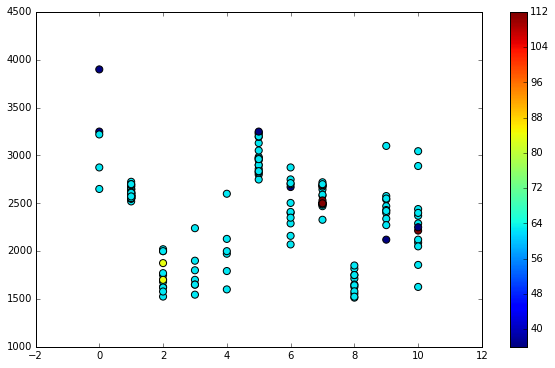

In [207]:
# distribución de grupos vs. altura vs. pesos estadísticos
listcomp12sc=np.loadtxt('listcomp12sc.txt')
plt.figure(figsize=(10,6))
plt.scatter(listcomp12sc[:,6],listcomp12sc[:,5],c=probarr12*112*8,s=50)
plt.colorbar()

(-5, 14)

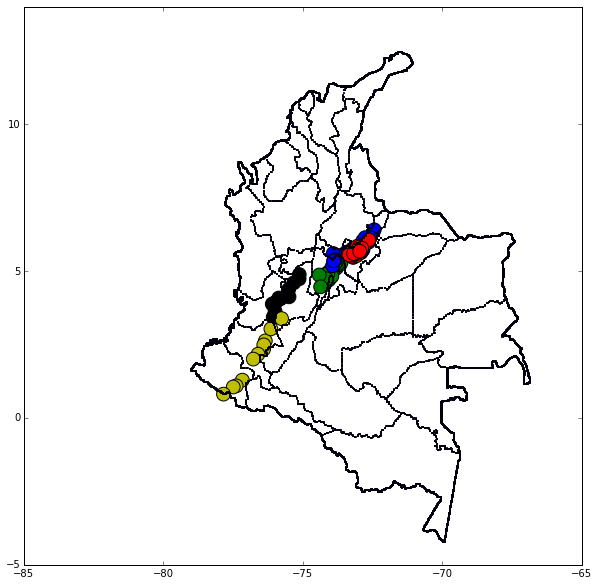

In [208]:
# clusters favoritos (encima de 2500 metros) son 7,9 cordillera oriental y 12 macizo colombiano
plt.figure(figsize=(10,10))
#filter=(np.ones(len(listcomp12[:,6]))).astype(bool)
filter=(listcomp12sc[:,6]==1)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='g',s=probarr12*112*8*3)
filter=(listcomp12sc[:,6]==5)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='b',s=probarr12*112*8*3)
filter=(listcomp12sc[:,6]==6)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='k',s=probarr12*112*8*3)
filter=(listcomp12sc[:,6]==7)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='r',s=probarr12*112*8*3)
filter=(listcomp12sc[:,6]==9)
plt.scatter(-listcomp12[:,3][filter],-listcomp12[:,4][filter],c='y',s=probarr12*112*8*3)
plt.scatter(colvec[:,0],colvec[:,1],s=1)

plt.xlim(-85,-65)
plt.ylim(-5,14)

In [81]:
filter=(listcomp12sc[:,6]==12)
print listcomp12sc[filter].shape

(24, 7)


In [82]:
filter=(listcomp12sc[:,6]==9)
print listcomp12sc[filter].shape

(13, 7)


In [219]:
# Se unen todos los datos (los iniciales) de lonlat para ubicarlos en el mapa (hay repetidos)
CodT=np.hstack((codeB,codeH,codeL,codeD))
LonT=np.hstack((lonB,lonH,lonL,lonD))
LatT=np.hstack((latB,latH,latL,latD))
np.savetxt('estaciones.txt',np.c_[CodT,LonT,LatT])
# después eliminamos repetidos y contamos cuantas variables mide cada estacion

In [103]:
%%bash
sort estaciones.txt | uniq -c > estaciones_medidas.txt
rm estaciones.txt

In [215]:
# 0=numero de variables medidas, 1=codigo de la estacion, 2,3=lonlat
EST=np.loadtxt('estaciones_medidas.txt')

In [216]:
# Alex Amaral-Rogers' Gaussian Kernel Contour generator
#returns the co-added gaussian kernels grid, and an array of numbers equaling the levels corresponding to the input sigma array.

#the inputs to the function is
#x = array of x data
#y = array of y data (must be the same size as x)
#x1,x2, y1,y2 the limits of the region in which you wish the plot to be.
#N the number of grid points in the axis. You can change this to be Nx, Ny if you preferred.
#sig = list of contour levels you want to plot in terms of sigma levels i.e. [0.5, 1, 2.0] is 0.5 sigma, 1 sigma, 2 sigma levels.


from scipy.stats import gaussian_kde
from scipy.special import erf

def CONTOURP(x, x1, x2, y, y1, y2, N, sig):
    xx = np.linspace(x1, x2, N)
    yy = np.linspace(y1, y2, N)

    XX, YY = np.meshgrid(xx, yy)
    values = np.vstack([x, y])
    positions = np.vstack([XX.ravel(), YY.ravel()])
    kernel = gaussian_kde(values)
    f = np.reshape(kernel(positions).T, XX.shape)

    PCT = 1.0 - np.cumsum(np.sort(f.ravel()))/np.sum(f)
    NN = np.sort(f.ravel())
    SO = [ ]
    for s in sig:
        SO += [NN[(np.abs(PCT - erf(s/np.sqrt(2.0)))).argmin()]]

    return f, SO

In [217]:
# Obtenemos los datos para hacer el contorno de densidad de datos
lnmin=-85
lnmax=-65
ltmin=-5
ltmax=14
nmesh=200
sigarray=[1.,2.]
CONT=CONTOURP(-EST[:,2],lnmin,lnmax,-EST[:,3],ltmin,ltmax,nmesh,sigarray);
xmesh=np.linspace(lnmin,lnmax,nmesh)
ymesh=np.linspace(ltmin,ltmax,nmesh)
Xmesh,Ymesh=np.meshgrid(xmesh,ymesh)

(-5, 14)

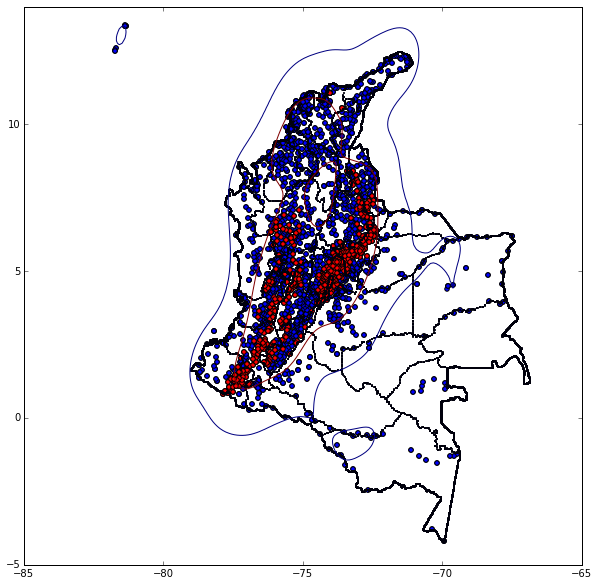

In [221]:
# contornos + azules= todas las estaciones dentro de sigarray=1,2 sigma
# rojos = cumplen al menos una de nuestras condiciones
plt.figure(figsize=(10,10))
plt.contour(Xmesh,Ymesh,CONT[0], levels = CONT[1])
plt.scatter(-LonT, -LatT)
plt.scatter(-DATT[:,1],-DATT[:,2],c='r')
plt.scatter(colvec[:,0],colvec[:,1],s=1)
plt.xlim(-85,-65)
plt.ylim(-5,14)